

# **Using Pre-trained Models in PyTorch to get Rank-1 and Rank-5 Accuracy**
1. We'll first load the pre-trained ImageNet model VGG16
2. We'll get the top 5 classes from a single image inference
3. Next we'll construct a function to give us the rank-N Accuracy using a few test images

---


In [1]:
# Load our pre-trained VGG16
import torchvision.models as models

model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 130MB/s]


## **Normalisation**

All pre-trained models expect input images **normalized** in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

`normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])`

In [2]:
from torchvision import datasets, transforms, models

data_dir = '/images'

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),])

**NOTE**

```net.eval()``` is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:

In [3]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### **Download our ImageNet Class Name and our Test Images**

In [4]:
# Get the imageNet Class label names and test images
!wget https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/imageNetclasses.json
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/imagesDLCV.zip
!unzip imagesDLCV.zip
!rm -rf ./images/class1/.DS_Store

--2023-06-18 06:37:10--  https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/imageNetclasses.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33567 (33K) [text/plain]
Saving to: ‘imageNetclasses.json’

imageNetclasses.jso 100%[===================>]  32.78K  --.-KB/s    in 0.003s  

2023-06-18 06:37:11 (9.19 MB/s) - ‘imageNetclasses.json’ saved [33567/33567]

--2023-06-18 06:37:11--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/imagesDLCV.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.143.102
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.143.102|:443... connected.
HTTP request se

## **Import our modules**

In [5]:
import torch
import json
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('imageNetclasses.json') as f:
  class_names = json.load(f)

# **Load and run a single image through our pre-trained model**

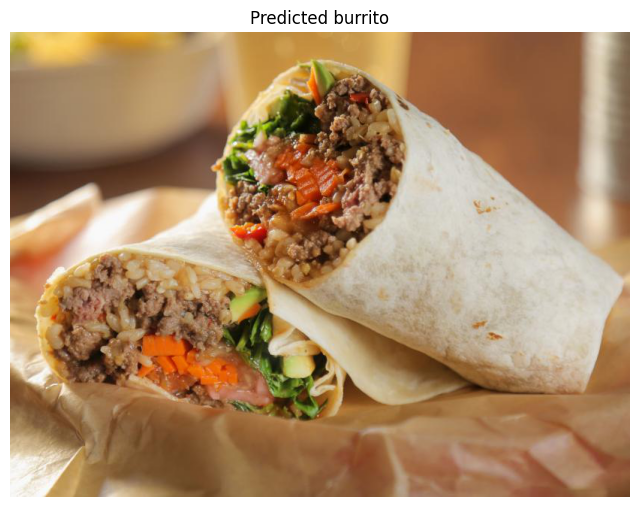

In [6]:
from PIL import Image
import numpy as np

image = Image.open('./images/class1/1539714414867.jpg')

# Convert to Tensor
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)
output = model(input)
index = output.data.cpu().numpy().argmax()
name = class_names[str(index)]

# Plot image
fig=plt.figure(figsize=(8,8))
plt.axis('off')
plt.title(f'Predicted {name}')
plt.imshow(image)
plt.show()

## **Get our Class Probabilities**

In [7]:
import torch.nn.functional as nnf

prob = nnf.softmax(output, dim=1)

top_p, top_class = prob.topk(5, dim = 1)
print(top_p, top_class)

tensor([[0.8718, 0.0177, 0.0176, 0.0162, 0.0066]], grad_fn=<TopkBackward0>) tensor([[965, 924, 931, 933, 923]])


In [8]:
# Convert to numpy array
top_class_np = top_class.cpu().data.numpy()[0]
top_class_np

array([965, 924, 931, 933, 923])

## **Create a class that gives us our class names**

In [9]:
def getClassNames(top_classes):
  top_classes = top_classes.cpu().data.numpy()[0]
  all_classes = []
  for top_class in top_classes:
    all_classes.append(class_names[str(top_class)])
  return all_classes

In [10]:
getClassNames(top_class)

['burrito', 'guacamole', 'bagel, beigel', 'cheeseburger', 'plate']

# **Construct our function to give us our Rank-N Accuracy**

In [11]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(16,16))

def getRankN(model, directory, ground_truth, N, show_images = True):
  # Get image names in directory
  onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]

  # We'll store the top-N class names here
  all_top_classes = []

  # Iterate through our test images
  for (i,image_filename) in enumerate(onlyfiles):
    image = Image.open(directory+image_filename)

    # Convert to Tensor
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    # Get our probabilties and top-N class names
    prob = nnf.softmax(output, dim=1)
    top_p, top_class = prob.topk(N, dim = 1)
    top_class_names = getClassNames(top_class)
    all_top_classes.append(top_class_names)

    if show_images:
      # Plot image
      sub = fig.add_subplot(len(onlyfiles),1, i+1)
      x = " ,".join(top_class_names)
      print(f'Top {N} Predicted Classes {x}')
      plt.axis('off')
      plt.imshow(image)
      plt.show()

  return getScore(all_top_classes, ground_truth, N)

def getScore(all_top_classes, ground_truth, N):
  # Calcuate rank-N score
  in_labels = 0
  for (i,labels) in enumerate(all_top_classes):
    if ground_truth[i] in labels:
      in_labels += 1
  return f'Rank-{N} Accuracy = {in_labels/len(all_top_classes)*100:.2f}%'

<Figure size 1600x1600 with 0 Axes>

In [12]:
# Create our ground truth labels
ground_truth = ['basketball',
                'German shepherd, German shepherd dog, German police dog, alsatian',
                'limousine, limo',
                "spider web, spider's web",
                'burrito',
                'beer_glass',
                'doormat, welcome mat',
                'Christmas stocking',
               'collie']

## **Get Rank-5 Accuracy**

Top 5 Predicted Classes spider web, spider's web ,barn spider, Araneus cavaticus ,garden spider, Aranea diademata ,black and gold garden spider, Argiope aurantia ,wolf spider, hunting spider


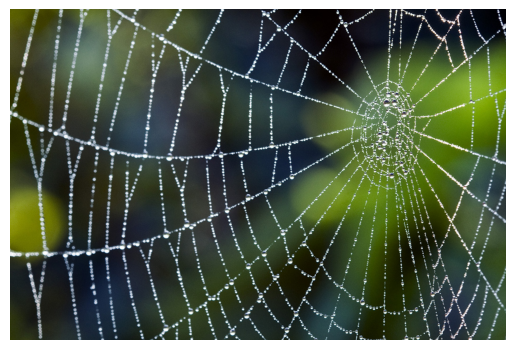

Top 5 Predicted Classes Christmas stocking ,pajama, pyjama, pj's, jammies ,purse ,apron ,safety pin


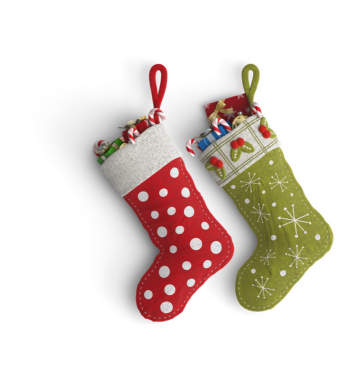

Top 5 Predicted Classes limousine, limo ,convertible ,minivan ,beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon ,bathtub, bathing tub, bath, tub


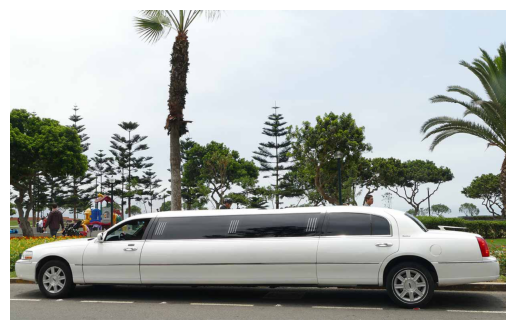

Top 5 Predicted Classes ice lolly, lolly, lollipop, popsicle ,Band Aid ,beaker ,pinwheel ,candle, taper, wax light


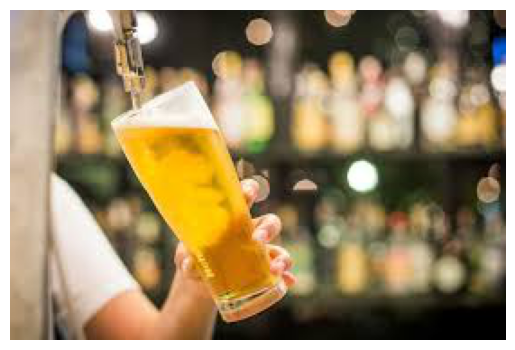

Top 5 Predicted Classes basketball ,face powder ,rugby ball ,tennis ball ,volleyball


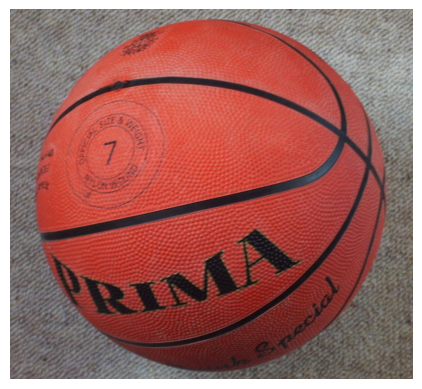

Top 5 Predicted Classes German shepherd, German shepherd dog, German police dog, alsatian ,Eskimo dog, husky ,Siberian husky ,Norwegian elkhound, elkhound ,kelpie


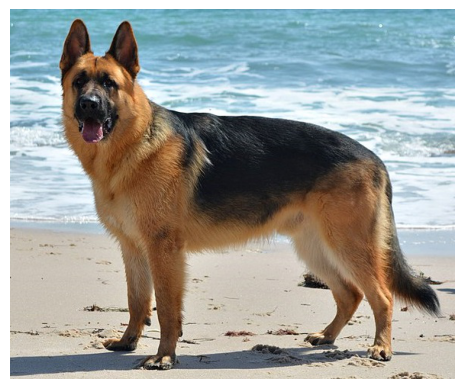

Top 5 Predicted Classes bath towel ,wool, woolen, woollen ,doormat, welcome mat ,envelope ,wallet, billfold, notecase, pocketbook


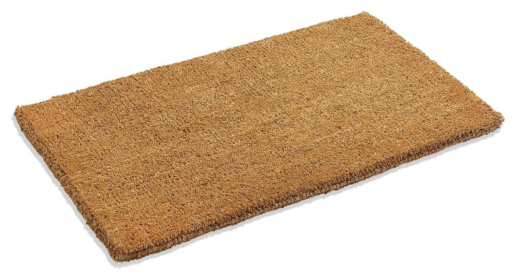

Top 5 Predicted Classes collie ,Shetland sheepdog, Shetland sheep dog, Shetland ,Samoyed, Samoyede ,Pomeranian ,white wolf, Arctic wolf, Canis lupus tundrarum


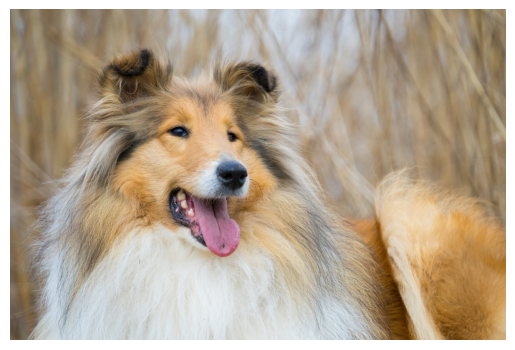

Top 5 Predicted Classes burrito ,guacamole ,bagel, beigel ,cheeseburger ,plate


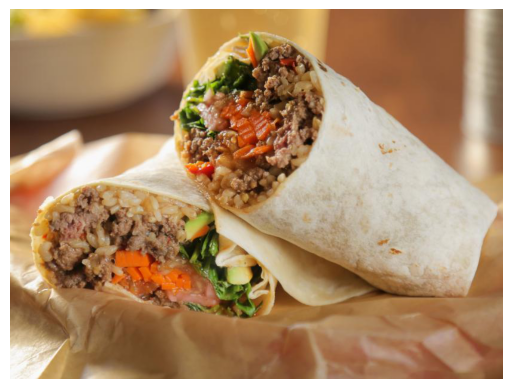

'Rank-5 Accuracy = 22.22%'

In [13]:
getRankN(model,'./images/class1/', ground_truth, N=5)

## **Get Rank-1 Accuracy**

Top 1 Predicted Classes spider web, spider's web


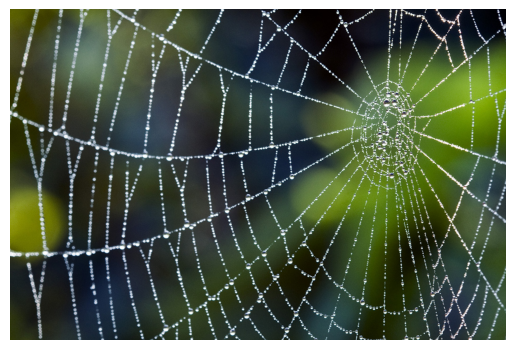

Top 1 Predicted Classes Christmas stocking


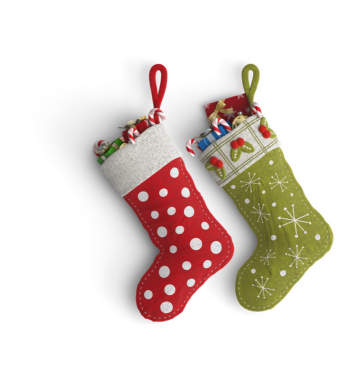

Top 1 Predicted Classes limousine, limo


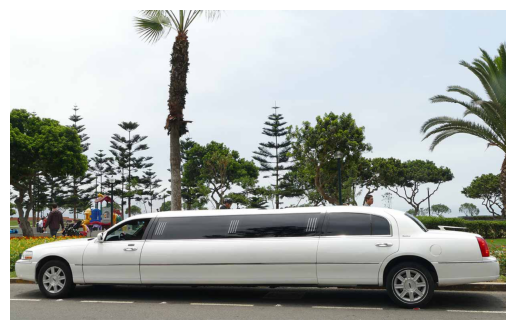

Top 1 Predicted Classes ice lolly, lolly, lollipop, popsicle


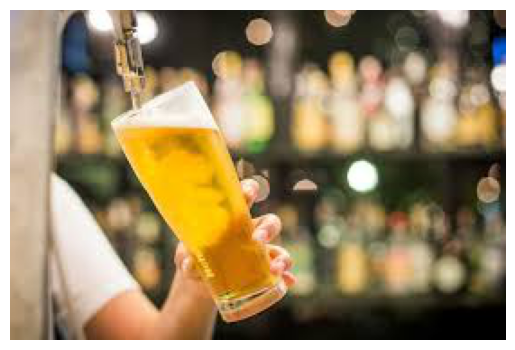

Top 1 Predicted Classes basketball


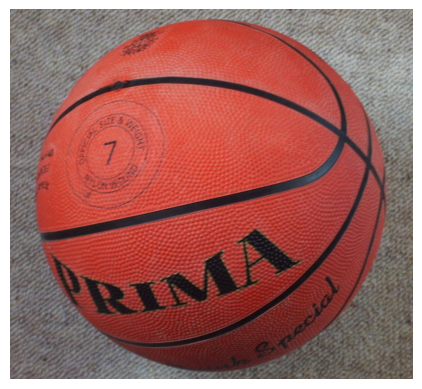

Top 1 Predicted Classes German shepherd, German shepherd dog, German police dog, alsatian


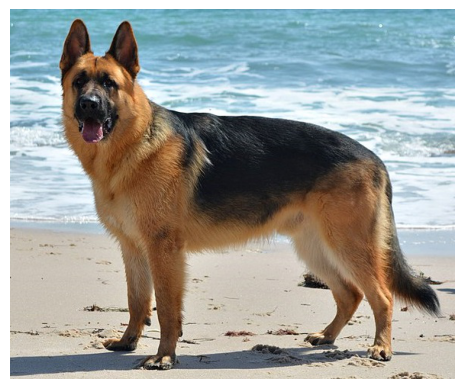

Top 1 Predicted Classes bath towel


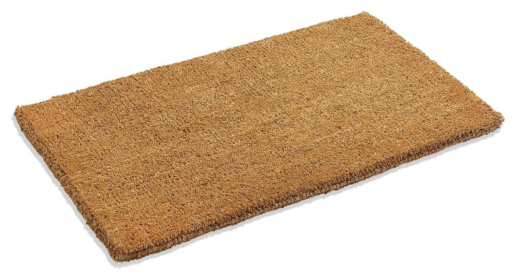

Top 1 Predicted Classes collie


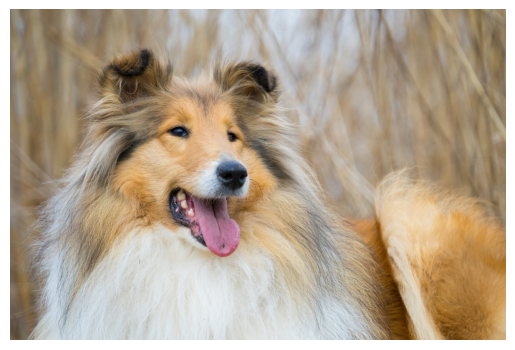

Top 1 Predicted Classes burrito


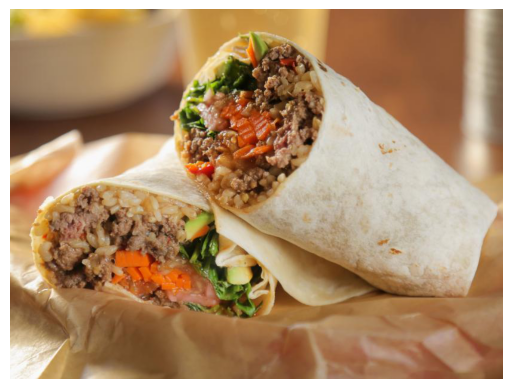

'Rank-1 Accuracy = 11.11%'

In [14]:
getRankN(model,'./images/class1/', ground_truth, N=1)

## **Get Rank-10 Accuracy**

Top 10 Predicted Classes spider web, spider's web ,barn spider, Araneus cavaticus ,garden spider, Aranea diademata ,black and gold garden spider, Argiope aurantia ,wolf spider, hunting spider ,black widow, Latrodectus mactans ,jellyfish ,matchstick ,bubble ,chain


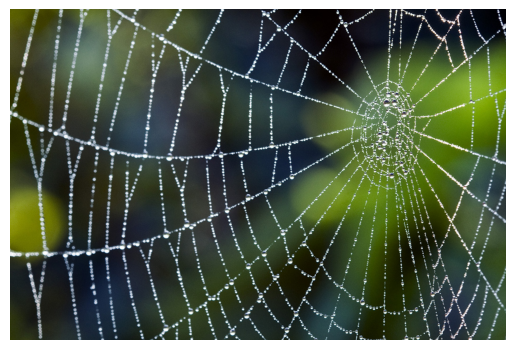

Top 10 Predicted Classes Christmas stocking ,pajama, pyjama, pj's, jammies ,purse ,apron ,safety pin ,diaper, nappy, napkin ,bib ,hair slide ,sock ,mailbag, postbag


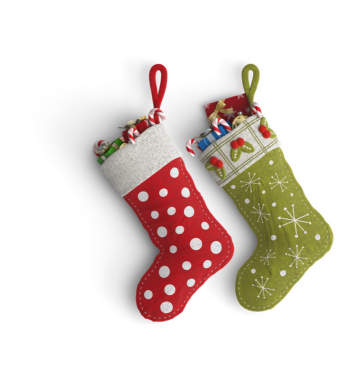

Top 10 Predicted Classes limousine, limo ,convertible ,minivan ,beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon ,bathtub, bathing tub, bath, tub ,tub, vat ,car wheel ,pickup, pickup truck ,sports car, sport car ,grille, radiator grille


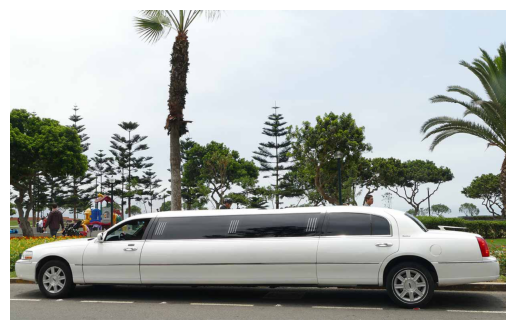

Top 10 Predicted Classes ice lolly, lolly, lollipop, popsicle ,Band Aid ,beaker ,pinwheel ,candle, taper, wax light ,plastic bag ,spatula ,lab coat, laboratory coat ,syringe ,nipple


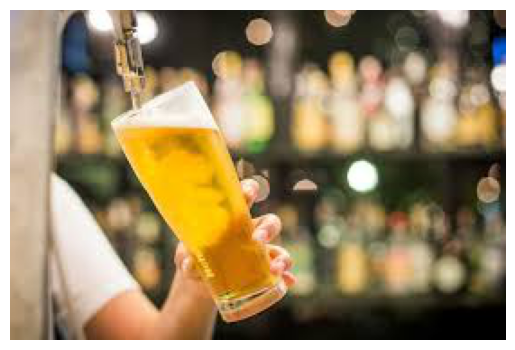

Top 10 Predicted Classes basketball ,face powder ,rugby ball ,tennis ball ,volleyball ,bottlecap ,ping-pong ball ,puck, hockey puck ,lotion ,sunscreen, sunblock, sun blocker


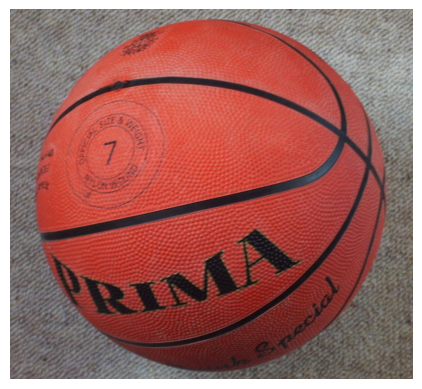

Top 10 Predicted Classes German shepherd, German shepherd dog, German police dog, alsatian ,Eskimo dog, husky ,Siberian husky ,Norwegian elkhound, elkhound ,kelpie ,white wolf, Arctic wolf, Canis lupus tundrarum ,malamute, malemute, Alaskan malamute ,malinois ,dingo, warrigal, warragal, Canis dingo ,Labrador retriever


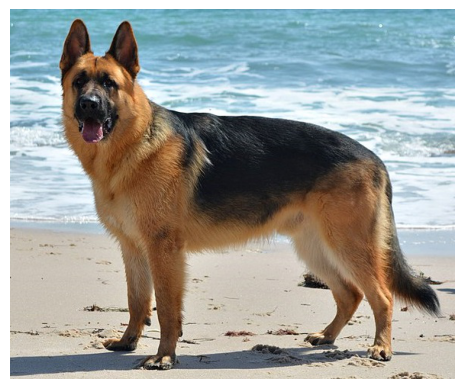

Top 10 Predicted Classes bath towel ,wool, woolen, woollen ,doormat, welcome mat ,envelope ,wallet, billfold, notecase, pocketbook ,handkerchief, hankie, hanky, hankey ,carton ,pencil box, pencil case ,book jacket, dust cover, dust jacket, dust wrapper ,binder, ring-binder


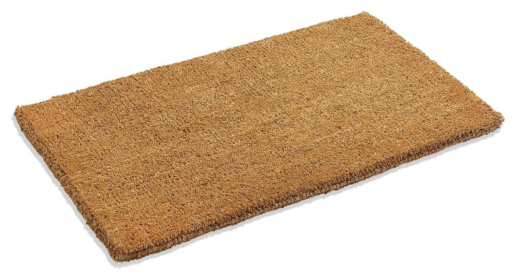

Top 10 Predicted Classes collie ,Shetland sheepdog, Shetland sheep dog, Shetland ,Samoyed, Samoyede ,Pomeranian ,white wolf, Arctic wolf, Canis lupus tundrarum ,Arctic fox, white fox, Alopex lagopus ,papillon ,Border collie ,Eskimo dog, husky ,Great Pyrenees


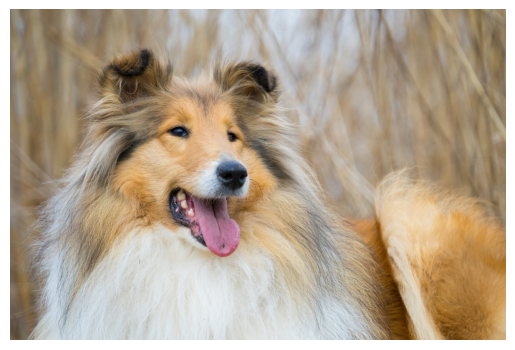

In [ ]:
getRankN(model,'./images/class1/', ground_truth, N=10)